# Autoencoderの中間出力ベクトルのクラスタリング

- k-means
- PCA
- Isomap
- t-SNE
- UMAP
- ...

In [1]:
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from pprint import pprint
import random
# import seaborn as sns
# sns.set(font='IPAexGothic')
import sklearn
from sklearn import datasets
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial import distance
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from vae_preprocess import dataset2d, dataset1d
# import vae_model
# importlib.reload(vae_model)
from vae_model import ConvAE, ConvAE_2dim, DenseAE_2dim, ConvVAE

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### データをロード

In [4]:
data_pkls = "./data_pkls/"
pkl_files = [data_pkls + "imgs128_1.pkl", data_pkls + "imgs128_2.pkl", data_pkls + "imgs128_3.pkl"]
# dataset1 = dataset1d(pkl_files)
# dataloader1 = torch.utils.data.DataLoader(dataset1, batch_size=1, shuffle=False, drop_last=False)
dataset2 = dataset2d(pkl_files)
dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=False, drop_last=False)

In [5]:
# print(len(dataset1))

In [6]:
dates = None
with open(data_pkls + "dates.pkl", "rb") as pkl:
    dates = pickle.load(pkl)
print(len(dates))

19154


In [7]:
img_size = dataset2[0].shape[1]
print(dataset2[0].shape)
print(img_size)

torch.Size([1, 128, 128])
128


## DenseAE_2dimモデル

In [11]:
img_size = 128
print(dataset1[0].shape)
print(img_size)

torch.Size([16384])
128


In [10]:
model = DenseAE_2dim(img_size)
model.load_state_dict(torch.load("./model_pths/DenseAE_2dim.pth"))
model.eval()
model.to(device)

DenseAE_2dim(
  (encoder): Sequential(
    (0): Linear(in_features=16384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=12, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=1024, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=1024, out_features=16384, bias=True)
    (9): Sigmoid()
  )
)

In [16]:
hidden_vecs = []
with torch.no_grad():
    for i, (date, batch_imgs) in enumerate(zip(dates, dataloader1)):
        outvecs = model.encoder(batch_imgs)
        outvecs = outvecs.flatten().to("cpu").numpy()
        hidden_vecs.append(outvecs)
hidden_vecs = np.array(hidden_vecs)
print(hidden_vecs.shape)

(19154, 2)


In [17]:
with open(data_pkls + "hidden_vecs2_linear.pkl", "wb") as f:
    pickle.dump(hidden_vecs, f)

In [18]:
hidden_vecs.transpose().shape

(2, 19154)

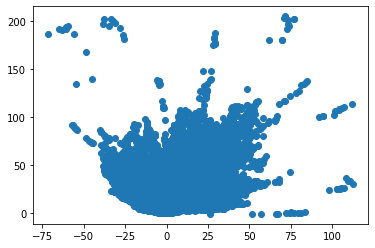

In [20]:
plt.clf()
plt.scatter(hidden_vecs.transpose()[0], hidden_vecs.transpose()[1], )
plt.show()

## ConvAEモデル

In [12]:
img_size = dataset2[0].shape[1]
print(dataset2[0].shape)
print(img_size)

torch.Size([1, 128, 128])
128


In [8]:
model = ConvAE(img_size)
model.load_state_dict(torch.load("./model_pths/ConvAE.pth"))
model.eval()
model.to(device)

ConvAE(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
  (t_conv6): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (t_conv5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (t_conv4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (t_conv3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2))
  (t_conv1): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(2, 2))
)

In [9]:
hidden_vecs = []
with torch.no_grad():
    for i, (date, batch_imgs) in enumerate(zip(dates, dataloader)):
        outvecs = model(batch_imgs, get_hidden=True)
        outvecs = outvecs.to("cpu").numpy()
        hidden_vecs.append(outvecs)
hidden_vecs = np.array(hidden_vecs)
print(hidden_vecs.shape)

(19154, 64)


In [10]:
with open(data_pkls + "hidden_vecs64.pkl", "wb") as f:
    pickle.dump(hidden_vecs, f)

## 二次元のモデル

In [ ]:
img_size = dataset2[0].shape[1]
print(dataset2[0].shape)
print(img_size)

In [13]:
model = ConvAE_2dim(img_size)
model.load_state_dict(torch.load("./model_pths/ConvAE_2dim.pth"))
model.eval()
model.to(device)

ConvAE_2dim(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(128, 2, kernel_size=(4, 4), stride=(1, 1))
  (t_conv6): ConvTranspose2d(2, 128, kernel_size=(4, 4), stride=(1, 1))
  (t_conv5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (t_conv4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (t_conv3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2))
  (t_conv1): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(2, 2))
)

In [14]:
hidden_vecs = []
with torch.no_grad():
    for i, (date, batch_imgs) in enumerate(zip(dates, dataloader2)):
        outvecs = model(batch_imgs, get_hidden=True)
        outvecs = outvecs.to("cpu").numpy()
        hidden_vecs.append(outvecs)
hidden_vecs = np.array(hidden_vecs)
print(hidden_vecs.shape)

(19154, 2)


In [15]:
with open(data_pkls + "hidden_vecs2.pkl", "wb") as f:
    pickle.dump(hidden_vecs, f)

In [16]:
hidden_vecs.transpose().shape

(2, 19154)

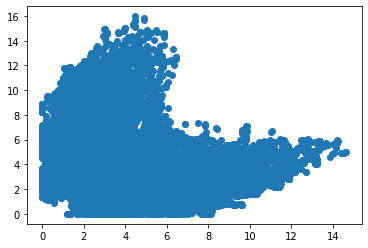

In [18]:
plt.scatter(hidden_vecs.transpose()[0], hidden_vecs.transpose()[1])
plt.show()

In [39]:
hvs = hidden_vecs[np.where(hidden_vecs.transpose()[0] > 12)[0].tolist()]

In [40]:
hvs = hvs[np.where(hvs.transpose()[1] > 4)[0].tolist()]

In [43]:
hvs = hvs[np.where(hvs.transpose()[1] < 5)[0].tolist()]

In [44]:
hvs.shape

(41, 2)

## ConvVAE

Variational AutoEncoderでやってみる

In [8]:
img_size = dataset2[0].shape[1]
print(dataset2[0].shape)
print(img_size)

torch.Size([1, 128, 128])
128


In [9]:
model = ConvVAE(img_size)
model.load_state_dict(torch.load("./model_pths/ConvVAE.pth"))
model.eval()
model.to(device)

ConvVAE(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(1, 1))
  (conv_mean): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv_var): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (t_conv7): ConvTranspose2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
  (t_conv6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1))
  (t_conv5): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
  (t_conv4): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (t_conv3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 16

In [10]:
orig_hidden_vecs = []
orig_hidden_mus = []
with torch.no_grad():
    for i, (date, batch_imgs) in enumerate(zip(dates, dataloader2)):
        mu, logvar = model.encoder(batch_imgs)
        # print(mu.shape, logvar.shape)
        orig_hidden_mus.append(mu.to("cpu").numpy())
        z = model.reparameterize(mu, logvar)
        # print(z.shape)
        z = z.to("cpu").numpy()
        orig_hidden_vecs.append(z)
orig_hidden_vecs = np.array(orig_hidden_vecs)
orig_hidden_mus = np.array(orig_hidden_mus)

In [11]:
print(orig_hidden_vecs.shape)
print(orig_hidden_mus.shape)

(19154, 1, 64, 1, 1)
(19154, 1, 64, 1, 1)


In [12]:
hidden_vecs = orig_hidden_vecs.reshape(19154, 64)
hidden_mus = orig_hidden_mus.reshape(19154, 64)
print(hidden_vecs.shape)
print(hidden_mus.shape)

(19154, 64)
(19154, 64)


In [13]:
pos = 1

In [14]:
print(hidden_mus[pos])

[ 3.9473615  -0.7365098  -0.7054787  -5.3280363  -1.2561283   1.4864023
  2.2176356  -1.4037298   0.20176503  1.1054223   4.095818    1.5009304
  3.0139606   1.4476737   1.4520558   3.354789    5.436976    0.10196125
 -2.449178   -1.3140168  -0.09259569 -0.97357947  1.4373865   2.376702
 -0.51607084  1.3275023   0.39475355 -6.0223627   0.02212711 -2.1235633
  0.85473406  1.6779454  -5.659926    4.0469413  -2.0458272  -0.4726695
 -2.55418     1.5424173   2.266089   -2.2232256   2.5915542   2.4645894
 -0.4396492  -0.5510379   2.6252604   4.1061163  -2.9520998   3.3732235
  2.3424609   2.5379705  -2.1582146  -1.3208964   1.3846549  -0.12351694
  1.156074   -3.3924274   0.575927    0.81023693  1.6895874   0.916026
  0.1381506  -0.2877684   1.5414125  -1.8605857 ]


In [15]:
print(hidden_vecs[pos])

[ 4.043632    0.21531671 -2.9074397  -4.583102   -0.6625386   1.5883193
  3.6462398  -2.4455166   0.859694    0.88935727  4.2569165   1.3689926
  0.61782575  1.0047752   0.9088964   5.3586097   5.572805    1.2484119
 -2.1174288  -1.1330276  -0.9498379  -3.5734856   1.8910278   0.9108124
 -0.8019795   2.1820378   0.01028523 -6.1156764  -1.3068038  -1.7306069
  1.0069925   3.171476   -5.3078713   4.8354464  -1.8777648  -0.46553677
 -3.7351398   1.3571787   3.4079654  -1.6349167   1.9812487   2.399657
 -2.148819    0.7625606   1.1105307   4.890256   -3.435019    3.3128116
  3.527059    2.487907   -0.68307376 -0.29494667  3.311254    0.4822292
  1.7990012  -0.94820404  0.57850754  0.46142894  2.41773    -0.22353399
 -0.35838696  0.3928322   1.7377689  -4.431187  ]


In [16]:
with open(data_pkls + "hidden_vecs64_convvae.pkl", "wb") as f:
    pickle.dump(hidden_vecs, f)

In [18]:
with open(data_pkls + "hidden_mus64_convvae.pkl", "wb") as f:
    pickle.dump(hidden_mus, f)

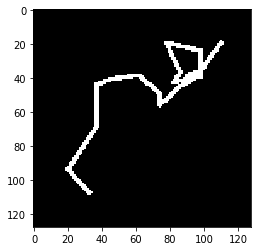

In [19]:
img = dataset2[pos]
plt.imshow(img.cpu().numpy()[0], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')

tensor([ 3.9474, -0.7365, -0.7055, -5.3280, -1.2561,  1.4864,  2.2176, -1.4037,
         0.2018,  1.1054,  4.0958,  1.5009,  3.0140,  1.4477,  1.4521,  3.3548,
         5.4370,  0.1020, -2.4492, -1.3140, -0.0926, -0.9736,  1.4374,  2.3767,
        -0.5161,  1.3275,  0.3948, -6.0224,  0.0221, -2.1236,  0.8547,  1.6779,
        -5.6599,  4.0469, -2.0458, -0.4727, -2.5542,  1.5424,  2.2661, -2.2232,
         2.5916,  2.4646, -0.4396, -0.5510,  2.6253,  4.1061, -2.9521,  3.3732,
         2.3425,  2.5380, -2.1582, -1.3209,  1.3847, -0.1235,  1.1561, -3.3924,
         0.5759,  0.8102,  1.6896,  0.9160,  0.1382, -0.2878,  1.5414, -1.8606],
       device='cuda:0')


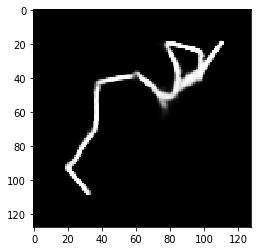

In [20]:
with torch.no_grad():
    img = dataset2[pos]
    z, _ = model.encoder(img[np.newaxis, :])
    print(z.flatten())
    # z = torch.tensor(hidden_mus[pos]).reshape(1, 64, 1, 1).to(device)
    output_img = model.decoder(z)
    plt.imshow(output_img.cpu().numpy()[0,0], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')

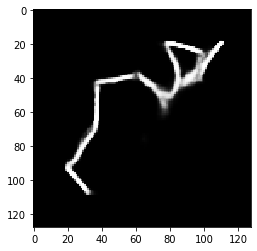

In [21]:
with torch.no_grad():
    z = torch.tensor(hidden_vecs[pos]).reshape(1, 64, 1, 1).to(device)
    output_img = model.decoder(z)
    plt.imshow(output_img.cpu().numpy()[0,0], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')

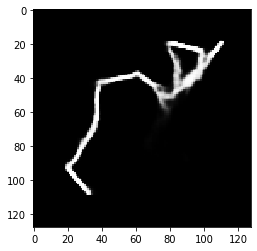

In [22]:
with torch.no_grad():
    img = dataset2[pos]
    output_img, _, _ = model.forward(img.reshape(1, img.shape[0], img.shape[1], img.shape[2]))
    plt.imshow(output_img.cpu().numpy()[0,0], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')

## クラスタリング

- k-meansは計算量が$O(Nk)$

In [23]:
def k_means(features, num_clusters):
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=10).fit(features)
    labels = kmeans_model.labels_
    return labels

In [24]:
hidden_vecs = None
with open(data_pkls + "hidden_vecs64_convvae.pkl", "rb") as f:
    hidden_vecs = pickle.load(f)

In [25]:
num_clusters = 1000
labels = k_means(hidden_vecs, num_clusters)

In [26]:
pkl_labels = data_pkls + "labels" + str(num_clusters) +  "_convvae" + ".pkl"

In [27]:
with open(pkl_labels, "wb") as f:
    pickle.dump(labels, f)

In [28]:
class cnn_dataset(torch.utils.data.Dataset):
    def __init__(self, pkl_imgs, pkl_labels, classes):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.data = self.load_pkls(pkl_imgs)
        self.data_size = len(self.data)
        self.labels = self.load_pkl(pkl_labels)
        self.classes = classes
        
    def __len__(self):
        return self.data_size

    def __getitem__(self, index):
        return torch.tensor(self.data[index], dtype=torch.float32)[np.newaxis, :].to(self.device), torch.eye(self.classes)[self.labels[index]].to(self.device)

    def load_pkls(self, pkls):
        data = []
        for pkl_file in pkls:
            with open(pkl_file, "rb") as pkl:
                data += pickle.load(pkl)
        return data
    
    def load_pkl(self, pkl_file):
        with open(pkl_file, "rb") as pkl:
            return pickle.load(pkl)

In [29]:
cnn_dataset2 = cnn_dataset(pkl_files, pkl_labels, classes=num_clusters)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

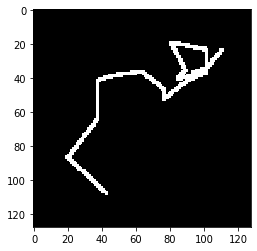

In [30]:
img, label = cnn_dataset2[0]
plt.imshow(img.to("cpu")[0], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
print(label)

### 検証

In [31]:
def imshow(dataset, poses, model = None, device = "cpu"):
    plt.clf()
    fig = plt.figure(figsize=(15.0, 15.0))
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(bottom=False, left=False, right=False, top=False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    for i, pos in enumerate(poses):
        ax = fig.add_subplot(np.round(np.sqrt(len(poses))).astype("int64") + 1, np.round(np.sqrt(len(poses))).astype("int64") + 1, i + 1)
        if model is None:
            ax.imshow(dataset[pos][0].to("cpu"), cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
        else:
            with torch.no_grad():
                output_img, _, _ = model(dataset[pos].unsqueeze(0))
                ax.imshow(output_img.to("cpu")[0,0], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
    fig.tight_layout()
    plt.show()

In [32]:
v_label = 10

In [35]:
poses = []
for i, (img, label) in enumerate(cnn_dataset2):
    if label.to("cpu")[v_label] == 1:
        poses.append(i)

In [36]:
len(poses)

21

<Figure size 432x288 with 0 Axes>

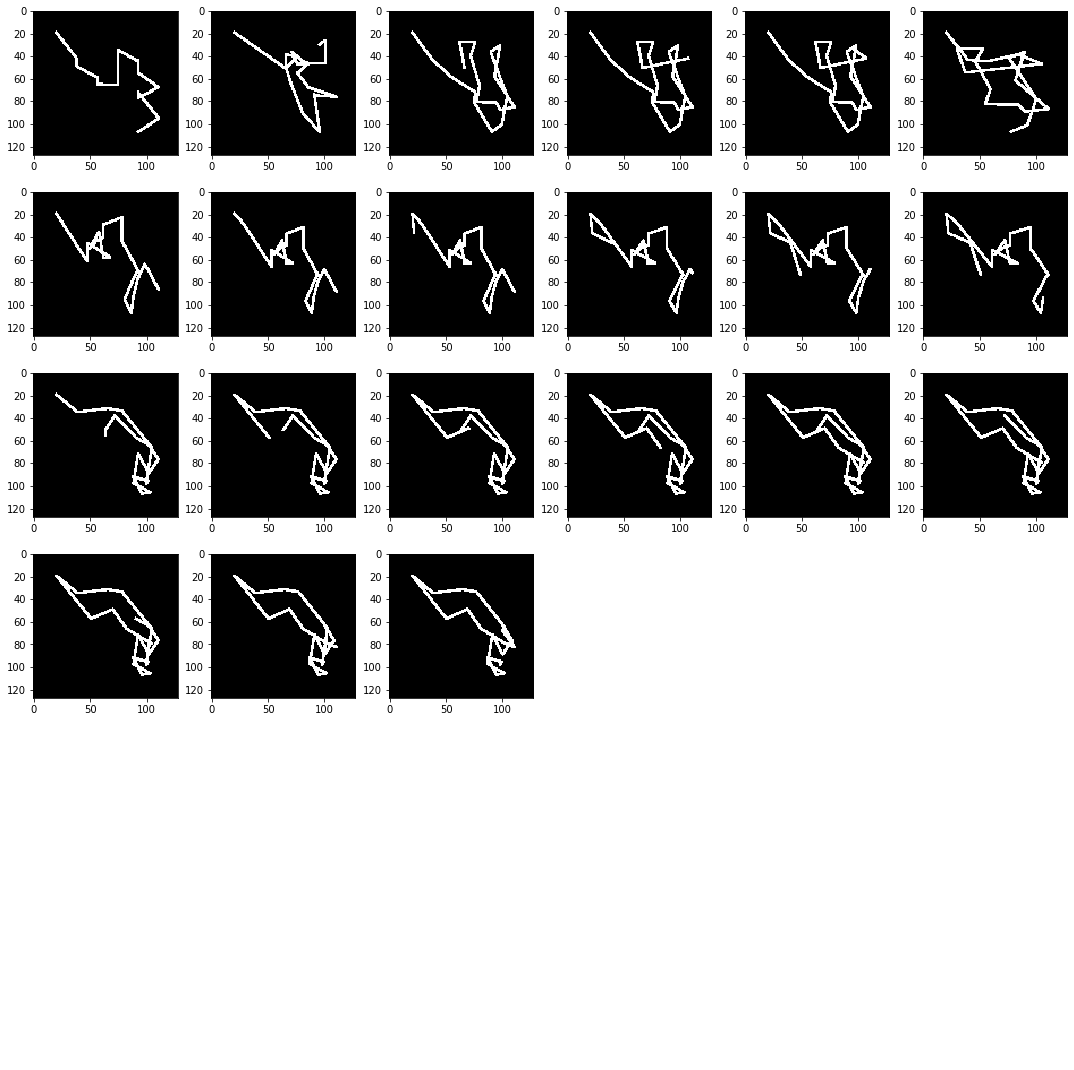

In [37]:
imshow(dataset2, poses)

<Figure size 432x288 with 0 Axes>

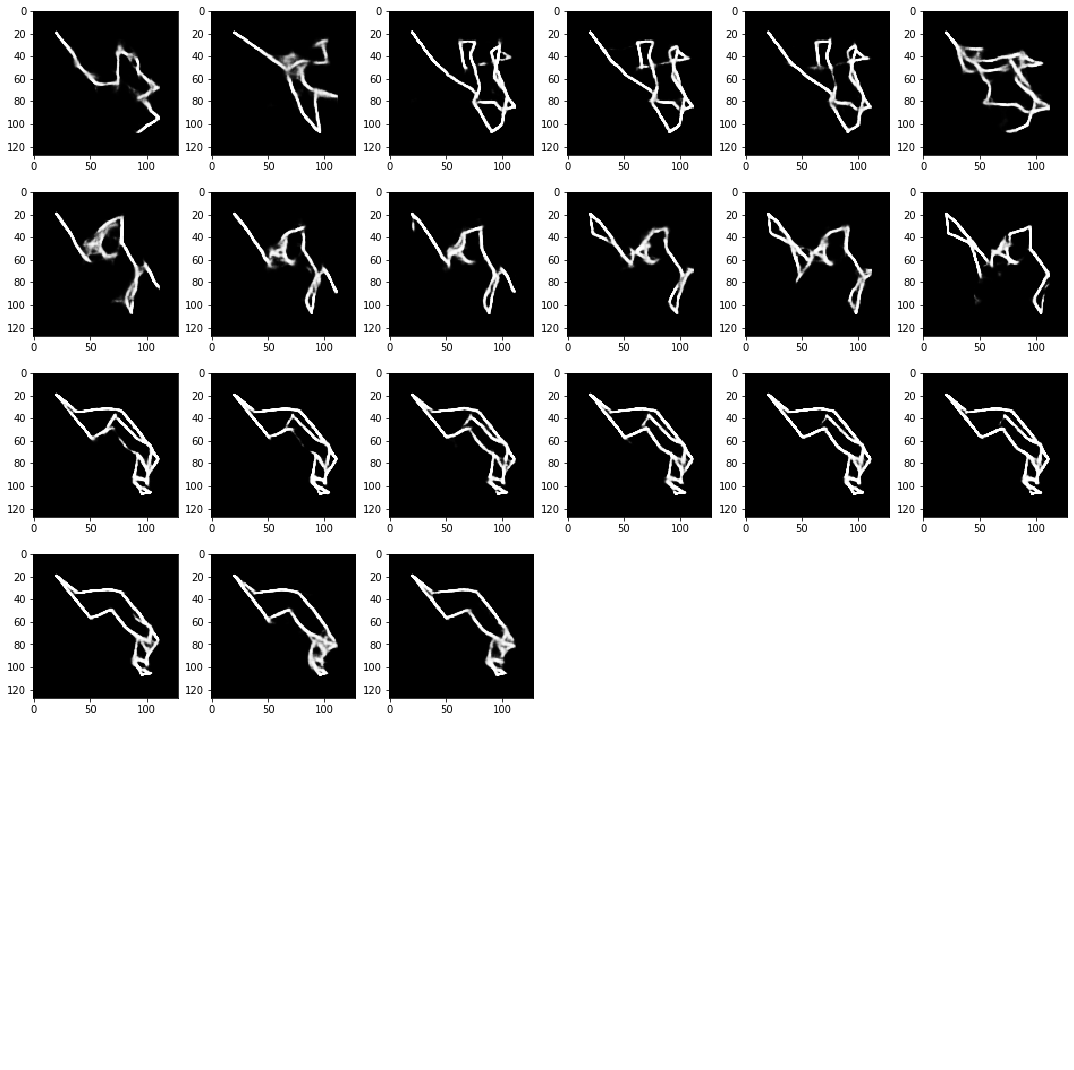

In [38]:
imshow(dataset2, poses, model=model)

In [55]:
sparse_hidden_vecs = hidden_vecs[::10]

In [56]:
sparse_hidden_vecs.shape

(1916, 64)

In [ ]:
pos = 2000

In [ ]:
target_vec = hidden_vecs[pos]

In [ ]:
for vec in hidden_vecs:
    distance.euclidean(a, b)

### AgglomerativeClustering

階層的クラスタリング手法

In [64]:
def hac(features, num_clusters):
    clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(features)
    labels = clustering.labels_
    return labels

In [ ]:
labels = hac(hidden_vecs, num_clusters)

In [68]:
pkl_labels = data_pkls + "labels" + str(num_clusters) +  "_convvae"+ "_hac" + ".pkl"
with open(pkl_labels, "wb") as f:
    pickle.dump(labels, f)

In [73]:
cnn_dataset = cnn_dataset(pkl_files, pkl_labels, classes=num_clusters)

In [74]:
poses = []
for i, (img, label) in enumerate(cnn_dataset):
    if label.to("cpu")[v_label] == 1:
        poses.append(i)
len(poses)

35

<Figure size 432x288 with 0 Axes>

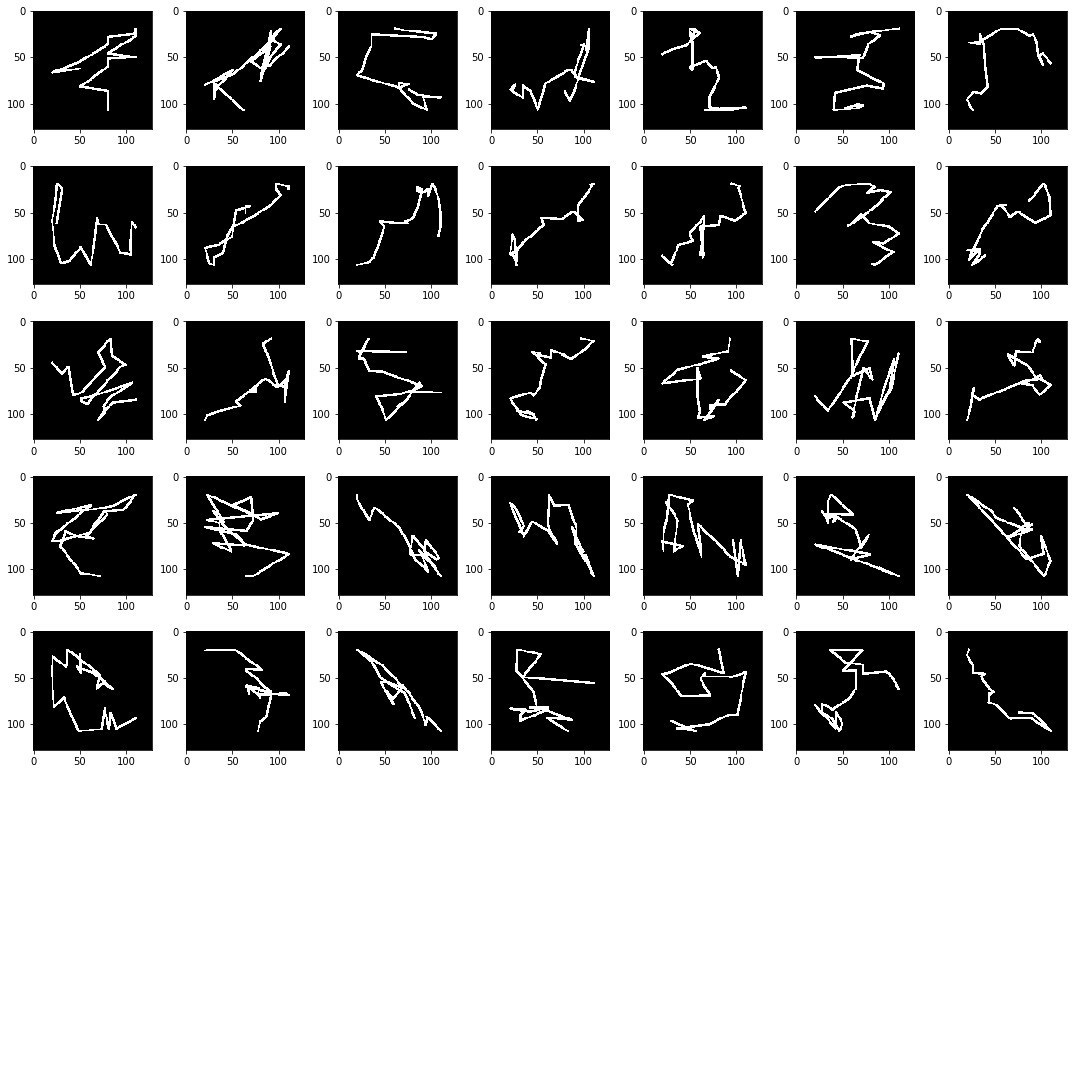

In [75]:
imshow(dataset2, poses)

## t-SNEで試してみる

In [41]:
num_clusters = 1000

In [42]:
labels = list(range(num_clusters))
# colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]

In [43]:
hvs64 = None
with open(data_pkls + "hidden_vecs64_convvae.pkl", "rb") as f:
    hvs64 = pickle.load(f)

In [62]:
hvs64.shape

(1916, 64)

In [61]:
hvs64 = sparse_hidden_vecs

In [45]:
# points = TSNE(n_components=2, random_state=0).fit_transform(hvs64[:1000])

KeyboardInterrupt: 

In [58]:
def visualize_zs(zs, labels):
    plt.clf()
    plt.figure(figsize=(20,20))
    # points = TSNE(n_components=2, random_state=0, perplexity = 10, n_iter=250).fit_transform(zs)
    points = TSNE(n_components=2, random_state=0).fit_transform(zs)
    for p, l in zip(points, labels):
        plt.scatter(p[0], p[1], marker="${}$".format(l), s=200)
    plt.show()

<Figure size 432x288 with 0 Axes>

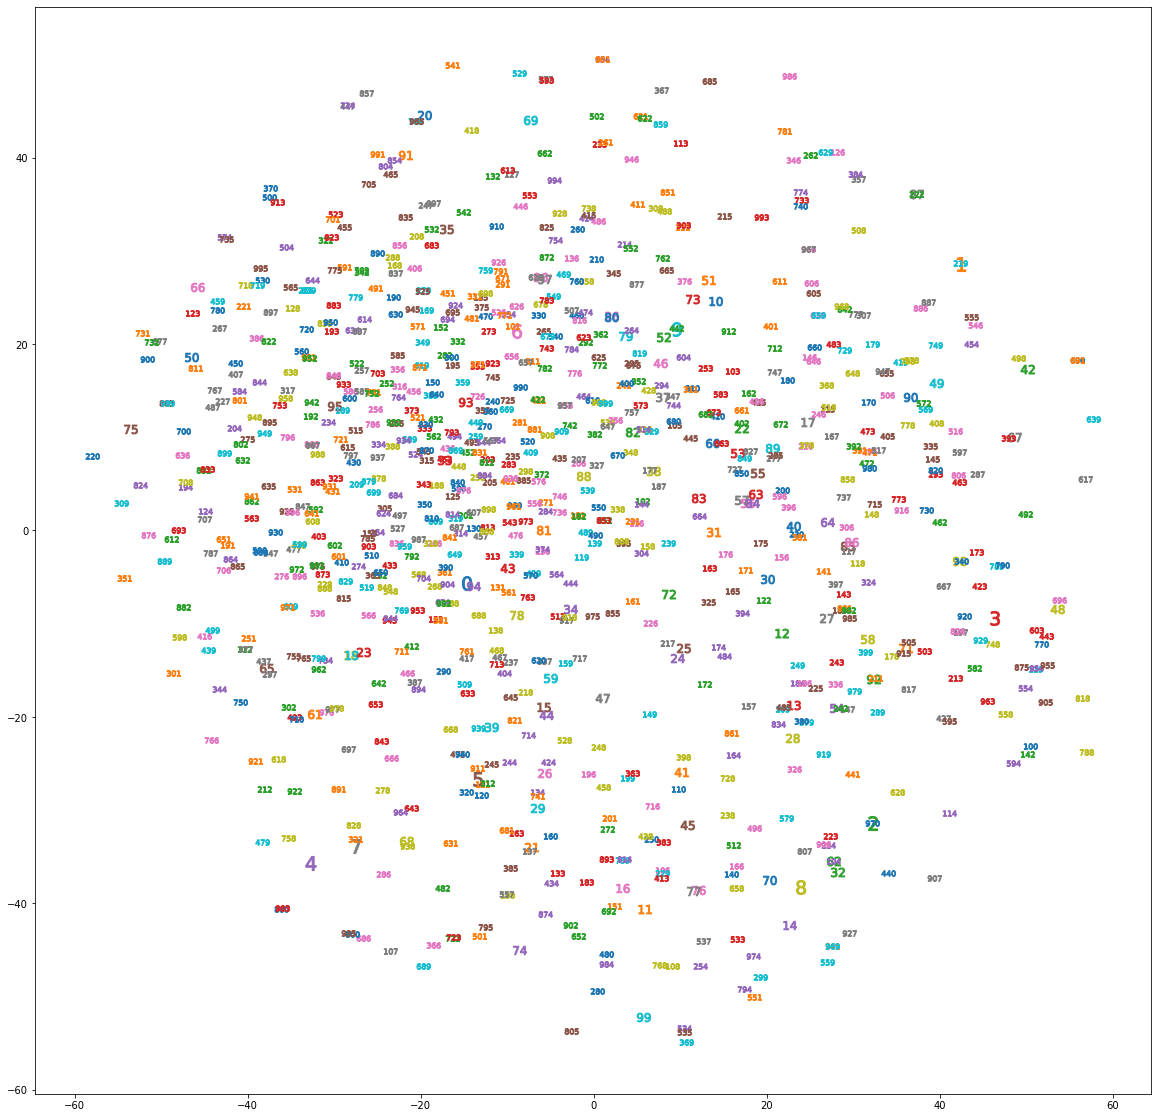

In [63]:
visualize_zs(hvs64, labels)

In [15]:
digits = datasets.load_digits()

In [16]:
print(digits)

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]]), 'target': array([0, 1, 2, ..., 8, 9, 8]), 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
        [ 0.,  0., 13., ..., 15.,  5.,  0.],
        [ 0.,  3., 15., ..., 11.,  8.,  0.],
        ...,
        [ 0.,  4., 11., ..., 12.,  7.,  0.],
        [ 0.,  2., 14., ..., 12.,  0.,  0.],
        [ 0.,  0.,  6., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
        [ 0.,  0.,  0., ...,  9.,  0.,  0.],
        [ 0.,  0.,  3., ...,  6.,  0.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., 12.,  0

(1797, 64)
(1797,)
(1797, 2)


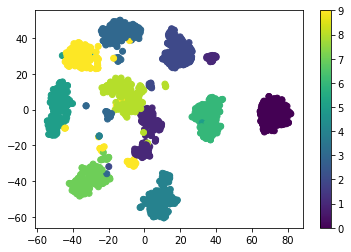

In [37]:
digits = datasets.load_digits()

print(digits.data.shape)

print(digits.target.shape)

X_reduced = TSNE(n_components=2, random_state=0).fit_transform(digits.data)

print(X_reduced.shape)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=digits.target)
plt.colorbar()

In [42]:
digits.data.shape

(1797, 64)

In [45]:
dataset[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
data_reduced = TSNE(n_components=2, random_state=0).fit_transform([img.flatten() for img in dataset.data])

print(data_reduced.shape)

plt.clf()
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.colorbar()

In [38]:
type(digits)

sklearn.utils.Bunch

In [39]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
         [ 0.,  0., 13., ..., 15.,  5.,  0.],
         [ 0.,  3., 15., ..., 11.,  8.,  0.],
         ...,
         [ 0.,  4., 11., ..., 12.,  7.,  0.],
         [ 0.,  2., 14., ..., 12.,  0.,  0.],
         [ 0.,  0.,  6., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
         [ 0.,  0.,  0., ...,  9.,  0.,  0.],
         [ 0.,  0.,  3., ...,  6.,  0.,  0.],
         ...,
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  0., ..., 10.,  0.,  0.]],
 
        [[ 0

In [23]:
import subprocess
subprocess.run(['jupyter', 'nbconvert', '--to', 'python', 'vae_tests.ipynb'])

CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'python', 'vae_clustering.ipynb'], returncode=0)